# Temperate Ecohydrology


Here we show a workflow for a simple hillslope.  Demos shown here include:

- spinup
- prescribed P - ET
- inclusion of a litter layer
- *Not yet complete:* transpiration from a vegetation model with prescribed LAI
- transpiration from a vegetation model with dynamic LAI
- *Not yet complete:* transpiration from a vegetation model and evaporation from a surface energy balance (the full model?)

Author: Ethan Coon

In [1]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import parse_xmf, parse_ats
import column_data, transect_data
import colors
import mesh
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar
import h5py

/Users/uec/codes/anaconda/2/5.1.0/base/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Spinup

For applications of temperate ecohydrology, spinup is all about getting antecedent soil moisture conditions correct.  There can be no expectation of getting reasonable hydrographs if the antecedent soil moisture field is wrong.

One way of doing this is to solve, to pseudo-steady state, the integrated hydrology problem with a constant source term that is given by the mean annual (or mean seasonal) precipitation minus evapotranspiration (P-ET) rate.  This can be solved for long times, using an adaptive timestep that grows as the solution approaches steady state.  This sets the mean background conditions for simulations with daily or other high-resolution inputs.

The first step is to provide an initial condition for that run which is hydrostatic with the water table at the surface.  Starting from fully saturated and drawing down to the steady state is faster and more efficient than starting from dry and filling up to the steady state.  To do this, we don't assume that this is a hillslope with fixed slope, but imagine that it is set by topography and therefore cannot be provided analytically.

ATS doesn't currently have a way of setting an initial condition as a function of depth, which would be ideal in this situation (contributions welcome!)  But ATS does support initializing from a column, in which a column solution is draped from the topography across the full mesh.  This is quite simple in this case, because it is hydrostatic and therefore a linear solution.  The file `../data/column_data.h5` provides a working version of this initialization strategy up to 100m soil depth.

In [ ]:
# create the column_data file
import numpy as np
import h5py

rho = 997
g = 9.80665

z = np.array([0, 100])
pres = 101325. + np.array([0.,100.])*rho*g

with h5py.File('data/column_data.h5', 'a') as fid:
    fid.create_dataset('z', data=z)
    fid.create_dataset('pressure', data=pres)


Given that initial condition, we solve to steady state.  In this solve, we often use a too-large Manning's coefficient.  This slows up the surface water, which is safe to do because we're looking at such long time scales.  Surface water is still much faster than subsurface water, and as long as we aren't trying to get high frequency hydrographs correct, this makes for much faster simulations (with longer timestep sizes) with little loss in predictive power.

This run is for 20,000 days and is plotted below.  The image is a bit hard to see without exaggerating in the vertical -- a better way of seeing these runs is to open it in VisIt.

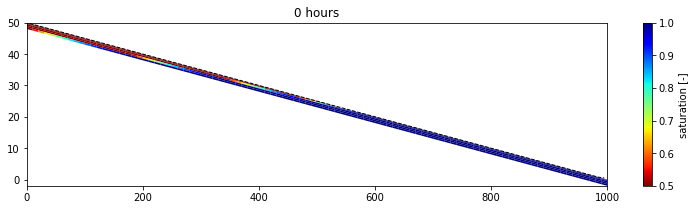

In [3]:
# plot the saturation at a few times
directory = "spinup-gi.demo"

keys, times, dat = parse_ats.readATS(directory, "visdump_data.h5", timeunits='d')
dats = column_data.column_data(['surface-ponded_depth','surface-elevation'], 
                               directory=directory, filename="visdump_surface_data.h5", 
                               mesh_filename="visdump_surface_mesh.h5", coord=0)

fig, ax = plt.subplots(1,1, figsize=(13,3))

def plot(i, ax):
    cax = colorbar.make_axes(ax, 'right')[0]
    cax.set_ylabel("saturation [-]")

    transect_data.plot(dat["saturation_liquid.cell.0"][keys[i]][:,0], ax, cax,
                       0.5, 1.0, directory=directory, cmap="jet_r", label="saturation [-]", linewidths=0)
    ax.plot(dats[0,0,:], dats[1,i,:]+dats[2,i,:], 'k--', linewidth=1)
    ax.set_title("{0} hours".format(3*i))
    
plot(0, ax)
plt.show()

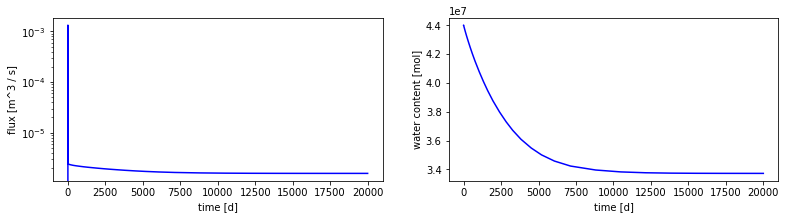

In [5]:
# plot the runoff and, more clearly, the total water content in the subsurface to see if we are at steadystate
fig, ax = plt.subplots(1,2, figsize=(13,3))

flux = np.loadtxt(os.path.join(directory, 'surface_outlet_flux.dat'))
ax[0].semilogy(flux[:,0]/86400., flux[:,1]/55000., 'b')
ax[0].set_xlabel('time [d]')
ax[0].set_ylabel('flux [m^3 / s]')

wc = np.loadtxt(os.path.join(directory, 'water_content.dat'))
ax[1].plot(wc[:,0]/86400., wc[:,1], 'b')
ax[1].set_xlabel('time [d]')
ax[1].set_ylabel('water content [mol]')

plt.show()


## Prescribed P - ET

Often precipitation and evapotranspiration are known from either a preexisting land model run, remotely sensed or point data (e.g. eddy flux towers and weather stations) or other approaches.  Here we do a few examples to generate datasets for use in ATS and then drive simulations with this prescribed data.


### Data processing

Below is an example of how to generate, from raw data, the input files needed by ATS for P, E, and T for these examples.  Included here is output from a CLM 4.5 run for the Asu Basin outside Manaus, Brazil.  This run provides daily data of a variety of the water balance fluxes, including precipitation, evaporation, and transpiration.  We read this file and generate the two HDF5 forcing files for use in ATS in the prescribed P-ET examples.

[('atmospheric_rainmms', '<f8'), ('surface_runoffmms', '<f8'), ('subsurface_runoffmms', '<f8'), ('infiltrationmms', '<f8'), ('interceptionmms', '<f8'), ('ground_evaporationmms', '<f8'), ('vegetation_evaporationmms', '<f8'), ('vegetation_transpirationmms', '<f8'), ('heat_flux_into_soilWm2', '<f8')]


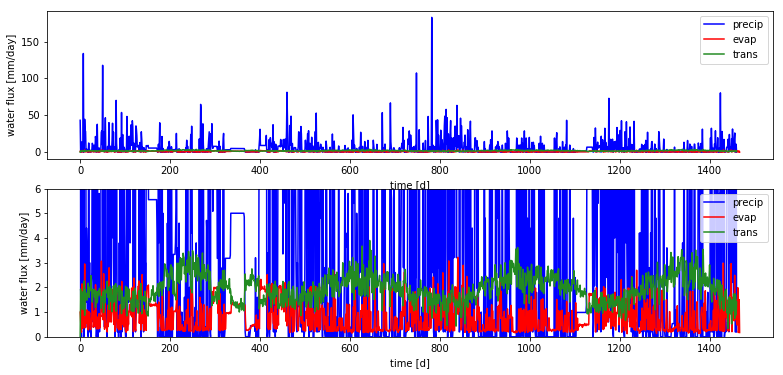

In [22]:
#
# load the data
#
data = np.genfromtxt("data/flux_output_w_fluxtowerR.txt", names=True)

# note this read with column headers -- the file contains:
print data.dtype

# daily data, converted to [s].  Note there are some units options in ATS, but it is easiest to write data in SI units.
times = np.array(range(len(data)))
times = times * 86400.

# precip, evap, and trans are all in [mm/s], and so must be converted to [m/s] for use in ATS
precip = 1.e-3 * data['atmospheric_rainmms']
evap = 1.e-3 * (data['vegetation_evaporationmms'] + data['ground_evaporationmms'])
trans = 1.e-3 * data['vegetation_transpirationmms']

# plot the data
fig, axs = plt.subplots(2,1,figsize=(13,6))
def plot(ax):
    fac = 1.e3 * 86400
    ax.plot(times/86400., precip*fac, 'b', label='precip')
    ax.plot(times/86000., evap*fac, 'r', label='evap')
    ax.plot(times/86400., trans*fac, color='forestgreen', label='trans')
    ax.legend(loc='upper right')
    ax.set_xlabel('time [d]')
    ax.set_ylabel('water flux [mm/day]')

plot(axs[0])
plot(axs[1])
axs[1].set_ylim(0, 6)

# write to disc
with h5py.File('data/prescribed_pet.h5','a') as fid:
    fid.create_dataset('time [s]', data=times)
    fid.create_dataset('precipitation [m s^-1]', data=precip)
    fid.create_dataset('evaporation [m s^-1]', data=evap)
    fid.create_dataset('transpiration [m s^-1]', data=trans)    
    fid.create_dataset('p_minus_et [m s^-1]', data=(precip - evap - trans))
    fid.create_dataset('p_minus_e [m s^-1]', data=(precip - evap))

plt.show()


### Daily forced simulations

Given the steady-state initial condition and the forcing data, we now run simulations forced by daily P-ET data.  Here we consider two choices -- first a run where P - ET is prescribed as a single entity as a function of time, and a second run where P - E is prescribed as a function of time while T is separated out.  

In the former case, the net water source is provided to the surface system (`prescribed_et-surface.xml`).  This is often problematic.  Specifically, in most places, T can be order P, and pulling that much water from the surface isn't always possible -- the top grid cell dries out and cannot get water to the surface fast enough.  Therefore a limiter must be applied to the ET to ensure it does not dry out a grid cell too much.  This is especially problematic in 3D integrated hydrology simulations, where often the ET is calculated via a column model using an "average" depth to water table, which is significantly less than the depth to water table at, for instance, the top of a hillslope in a 3D run.

In the latter case, P-E is provided as a source to the surface system, while T is then distributed to a subsurface sink using a root profile for Plant Functional Type (PFT)-based vegetation (`prescribed_et-distributed.xml`).  This is much more effective because the PFT rooting-depth based transpiration allows T to pull from depth, and has a native limiter on it based on soil moisture (or is it mafic potential?).  Note that the E may _still_ need to be limited, but typically, as E < P,T, this is less frequently a problem and typically full evaporation is taken and the limiter can be quite less of an issue.  

In these runs we did need a limiter for the surface ET case, but not for the distributed T case.

Note the limiters used here are quite naive -- better limiters should be implemented before this approach is used for real science.

Note that the hydrographs in the distributed case are drier, because ET was not limited and full transpiration was taken.

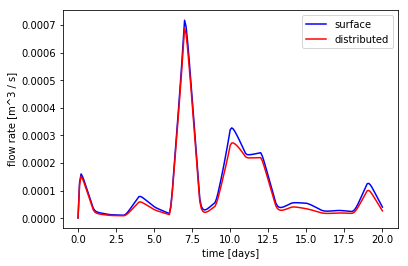

In [24]:
directory_p_et = 'prescribed_et-surface.demo'
directory_p_e_t = 'prescribed_et-distributed.demo'

# plot the hydrographs
fig, ax = plt.subplots(1,1)

def plot(ax, directory, name, color):
    flux = np.loadtxt(os.path.join(directory, 'surface_outlet_flux.dat'))
    ax.plot(flux[:,0]/86400., flux[:,1]/55000., color=color, label=name)

plot(ax, directory_p_et, 'surface', 'b')
plot(ax, directory_p_e_t, 'distributed', 'r')
ax.legend()
ax.set_xlabel('time [days]')
ax.set_ylabel('flow rate [m^3 / s]')
plt.show()

### Prescribed LAI, calculated transpiration

More realistic than prescribing transpiration is to actively calculate transpiration as a function of photosynthesis.  This can be done through vegetation models, which actively simulate a carbon cycle and predict LAI and photosynthesis, or through a biophysics model, which takes as input a prescribed LAI as a function of time (including, e.g. seasonal variations) and calculates photosynthesis, stomatal conductance, and transpiration.

These approaches need no limiters -- the limiter is in the stomatal conductance term, which is itself a function of soil moisture or mafic potential.

**TO DO** This is not yet implemented -- the veg model and the biophysics calculation are in the same PK, and need to be refactored and split before this is possible.  _ETC_

### Dynamic LAI, calculated transpiration

To do dynamic LAI and then calculate transpiration, a carbon cycle is needed.  This includes models of biophysics, and plant growth/allocation.  When this is done, a soil carbon model is solved as well, based on a century model.

The vegetation model in ATS is a big-leaf model. (This is probably appropriate for the resolution at which ATS typically is solved -- canopy gaps are likely as big as or comparable in size to the typical ATS cell.)  It is a multi-leaf layer, multi-PFT (i.e. coexisting, height-ordered PFTs which shade each other) model, written by Chonggang Xu (LANL).

To use this model, vegetation must first be spun up to annual steadystate, and forced with meteorological data.  Here we will use DayMet, which provides daily historical QA'd datasets for met data on a 1km continental US grid.  These datasets were created using DayMet for the Coweeta Hydrologic Laboratory:

```python $ATS_SRC_DIR/tools/utils/daymet_to_ats.py 35.0599 -83.4306```

and then smoothed to generate spinup data via:

```python $ATS_SRC_DIR/tools/utils/smooth_met.py -n 10 daymet_raw_35p0599_-83p4306.h5```

**Note:** this needs some real work, whether via parameterization or other code cleanup, to get some more stable veg cases.  **ETC**

Text(0,0.5,u'total LAI [-]')

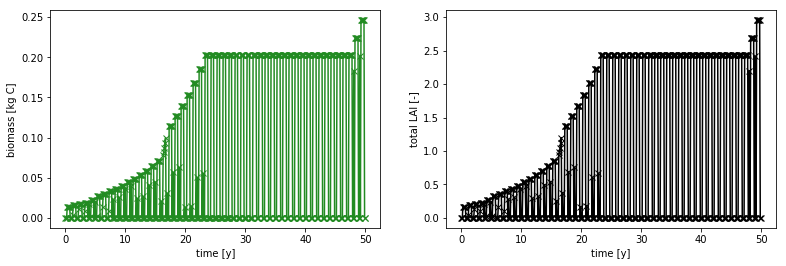

In [76]:
#
# load and plot the spinup results
#
directory = 'spinup-vegetation.demo'

keys, times, dat = parse_ats.readATS(directory=directory, base='visdump_surface_data.h5')

fig, axs = plt.subplots(1,2, figsize=(13,4))
biomass = parse_ats.getSurfaceData(keys, dat, 'surface-leaf_biomass.cell.deciduous')
axs[0].plot(times, biomass, '-x', color='forestgreen', label='deciduous biomass')

lai = parse_ats.getSurfaceData(keys, dat, 'surface-total_leaf_area_index.cell.0')
axs[1].plot(times, lai, 'k-x')
axs[0].set_xlabel('time [y]')
axs[0].set_ylabel('biomass [kg C]')
axs[1].set_xlabel('time [y]')
axs[1].set_ylabel('total LAI [-]')
